# CoSP Assignment 3: Style Coordination

### Submission details:

* **Deadline: Wednesday 22/11/2017 at 20:00** Please submit your work on time. Late submissions will not be graded.
* You can do the assignment either individually, or in a group of 2 people.
* Submit the .ipynb file containing your code **via email to nadine.theiler@uva.nl using "[CoSP17] Assignment 3" as a subject line**. Rename the .ipynb file so that the file name contains your last name(s), e.g. assignment3_ntheiler.ipynb. If you submit your answers as a group, clearly indicate this in the name of the file, and preferably also in the comment section.
* For every question, it is indicated how many points you can maximally get for it. The total number of points for the assignment is 100. The assignment also contains a bonus question for which you can get 10 points.

### Some technical remarks:
* You should write your code and answers **in this Jupyter notebook**. The blocks for code and text are already created, just click on them and change the content.
* Make sure we can run the notebook. If you can run your notebook from the folder *cosp2017_practical* you downloaded during the introductory practical session without modifications, then your setup should be ok and we should be able to run your notebook too. 
* If you want to run a particular cell in the notebook, make sure you also run the cells above it that it depends on.
* Make sure to put "%pylab inline" somewhere in the beginning of your notebook, such that plots will appear inline.

In [1]:
# imports
%matplotlib inline
from swda_time import CorpusReader
from swda_time import Transcript
import matplotlib.pyplot as plt
import numpy as np
import scipy
from collections import defaultdict

corpus = CorpusReader('swda_time', 'swda_time/swda-metadata-ext.csv')

## Coordination

In this assignment we will explore style coordination between two speakers in a conversation. We will use the linguistic coordination measure proposed by Danescu-Niculescu-Mizil et al. (2012), which is based on the common occurrence of linguistic markers (types of function words, such as quantifiers or prepositions). The authors define the coordination of speaker B towards speaker A with respect to some marker $m$ as the conditional probability that a turn by speaker B contains a certain linguistic marker $m$ given that speaker A used this marker in the previous turn, minus the overall probability that speaker B uses this marker in any turn:

$C^m(B,A) = P(T^m_B|T^m_A) - P(T^m_B)$

Where $P(T^m_B|T^m_A)$ denotes the probability that speaker B uses marker $m$ in a turn immediately following a turn in which speaker A used this marker. All probabilities are estimated using relative frequency estimation from the corpus counts. 

The linguistic style markers used by Danescu-Niculescu-Mizil et al. are 8 categories of words: articles, auxiliary verbs, conjunctions, high-frequency adverbs, impersonal pronouns, personal pronouns, prepositions, and quantifiers. An utterance or turn is said to exhibit a certain marker $m$ if it contains a word from a list of words associated with this marker. 

In this assignment you will use the lists of markers compiled by Noble & Fernández (2015), available in the file *markers.py* which you find in the folder *cosp2017_practical*.

**References**

C. Danescu-Niculescu-Mizil, L. Lee, B. Pang and J. Kleinberg (2012). Echoes of power: Language effects and power differences in social interaction, in Proceedings of WWW. [http://www.cs.cornell.edu/~cristian/Echoes_of_power.html]

B. Noble and R. Fernández (2015). Center stage: How social network position shapes linguistic coordination, in Proceedings of CMCL. [http://www.aclweb.org/anthology/W15-1104.pdf]

In [2]:
from markers import *
print prepositions

['of', 'in', 'to', 'for', 'with', 'on', 'by', 'at', 'from', 'as', 'into', 'about', 'like', 'after', 'between', 'through', 'over', 'against', 'under', 'out of', 'without', 'within', 'during', 'before', 'such as', 'towards', 'around', 'upon', 'including', 'among', 'across', 'off', 'behind', 'since', 'because of', 'as well as', 'rather than', 'until', 'according to', 'up to', 'despite', 'near', 'above', 'per', 'along', 'away from', 'throughout', 'outside', 'round', 'beyond', 'worth', 'in terms of', 'down', 'on to', 'up', 'due to', 'inside', 'as to', 'instead of', 'plus']


## Collecting frequency information

To compute the amount of coordination within a conversation, we will have to do some frequency counting. We provide a (rather long) function that you can use to do all the counting in one iteration through a transcript (to prevent looping through the transcript multiple times). Given as input a list or set with marker words and a Transcript object, the function computes: 

* the number of turns per speaker, 
* the baseline occurence of markers in the turns of both speaker A and B, and 
* the number of times the occurence of the use of a marker in a turn of speaker A followed the use of a marker in a consecutive turn of speaker B. 

These three counts are stored in three dictionaries called `turns`, `markers` and `markers_conditional`, respectively, with the speakers as keys and the counts as values. Entry `markers_conditional(B)` contains the counts C(m in B|m in A), where B's turn was following the turn of A. Utterances tagged as backchannels and fragments are ignored when computing the turns.

In [3]:
def get_frequency_info(marker_words, transcript):
    """
    Compute frequency information for linguistic markers for
    given transcript. Ignore backchannels and fragments
    when counting turns
    
    :param marker_words:     a set with linguistic markers
    :param transcript:  a transcript object
    
    :return:    tuple (n_turns, markers, markers_condititional)
      turns:                dictionary with number of turns per speaker
      markers:              dictionary with baseline occurrence of markers in turns of A and B
      markers_conditional:  dictionary with number of markers given marker occurred in previous turn
    """
    
    # count dictionaries to return
    turns = {'A':0, 'B':0}                   # number of turns
    markers = {'A':0, 'B':0}                 # number of words in marker_word list
    markers_conditional = {'A':0, 'B':0}     # entry A contains C(m in A|m in B) and vice versa
    
    # helper dicts
    markers_prev = {'A':False, 'B':False}
    cur_speaker = 'A'
    cur_turn_index = 1
    words_turn = []
    other_speaker = {'A':'B', 'B':'A'}
    
    # make set of marker_words
    marker_words = set(marker_words)

    # loop over utterances
    for utt in transcript.utterances:

        if utt.caller == cur_speaker:
            # turn did not change, update words
            words_turn += utt.pos_words()
        
        else:
            # speaker changed, check for backchannels and
            # fragments, that are not considered turn changes
            if utt.damsl_act_tag() in ['b', 'x']:
                continue
            
            # turn changed, test if markers were in turn to update counts
            if marker_words.intersection(set([word.lower() for word in words_turn])) != set([]):
                markers_prev[cur_speaker] = True
                markers[cur_speaker] += 1
                if markers_prev[utt.caller] == True:                    
                    markers_conditional[cur_speaker] += 1
                
            else:
                markers_prev[cur_speaker] = False
                    
            # update counts and change speaker increase number of turns
            turns[cur_speaker] +=1
            words_turn = utt.pos_words()
                   
            cur_speaker = utt.caller
            
    # process last turn  
    turns[cur_speaker]+=1
    if marker_words.intersection(set([word.lower() for word in words_turn])) != set([]):
        markers[cur_speaker] += 1
        if markers_prev[other_speaker[cur_speaker]] == True:
            markers_conditional[cur_speaker] += 1
            
    return(turns, markers, markers_conditional)

## Computing style coordination

We can use this function to compute style coordination, for instance:

In [4]:
# load transcript and get info
trans = Transcript('swda_time/sw2005.csv', 'swda_time/swda-metadata-ext.csv')
n_turns, n_markers, markers_conditional = get_frequency_info(prepositions, trans)

# compute baselines
baseline_A = float(n_markers['A'])/n_turns['A']
baseline_B = float(n_markers['B'])/n_turns['B']

# compute conditionals
cond_A_B = float(markers_conditional['A'])/n_markers['B']
cond_B_A = float(markers_conditional['B'])/n_markers['A']

# compute coordination
coordination_A = cond_A_B -baseline_A
coordination_B = cond_B_A -baseline_B

print "Coordination of A towards B w.r.t prepositions: %f\nCoordination of B towards A w.r.t prepositions: %f" % (coordination_A, coordination_B)

Coordination of A towards B w.r.t prepositions: -0.210317
Coordination of B towards A w.r.t prepositions: -0.069565


**Question 1 (5 points)**

Write a function *compute_coordination(transcript, speaker, markers)* that takes as input a transcript, a speaker ('A' or 'B') and a list with markers (represented by lists) and that outputs a dictionary with the degree of coordination of the input speaker towards the other speaker with respect to specific markers. You can use the previous function in a loop, or adapt it such that it considers all the markers in one go. Also write a few lines of documentation for your function, describing what the inputs and outputs look like.

In [5]:
# function computing coordination between different speakers
# with respect to certain markers
def compute_coordination(transcript, speaker, markers):
    """
    Returns a list with the degree of coordination of the input speaker 
    towards the other speaker with respect to specific markers given a conversation transcript. 
    The list is sorted in the same order as the inout markers list.
        
    :param transcript: SWDA transcript object     
    :param speakers: speaker A or B       
    :param markers: list of markers to be analysed. Choice of [articles, auxiliary_verbs, conjunctions, 
                    adverbs, impersonal_pronouns, personal_pronouns, prepositions, quantifiers]
    :return: a list with the alignments indexed by the position of the marker in the input list
    """
    # householding 
    cur_speaker = 'A'
    cur_turn_index = 1
    words_turn = []
    turns = 0
    
    # Collection dicts
    speaker_markers = defaultdict(lambda : 0)   
    markers_conditional = defaultdict(lambda : 0)  
    
    # Auxilliary dicts
    other_markers = defaultdict(lambda : 0)
    markers_prev = defaultdict(lambda : False)
    
    # Get list of marker sets
    marker_sets = [set(marker_list) for marker_list in markers]
   
    # loop over utterances
    for utt in transcript.utterances:
        if utt.caller == cur_speaker:
            # turn did not change, update words
            words_turn += utt.pos_words()        
        else:            
            # speaker changed, check for backchannels and
            # fragments, that are not considered turn changes
            if utt.damsl_act_tag() in ['b', 'x']:
                continue
                
            # Update current speaker 
            cur_speaker = utt.caller
            
            # If turn taking speaker is the relevant speaker, increase the turn counter 
            # and update other and prev turn markers (adding statistics for the other speaker's previous turn)
            if cur_speaker == speaker:
                # Increase number of turns
                turns += 1
                
                for marker_id, marker_words in enumerate(marker_sets):            
                    if marker_words.intersection(set([word.lower() for word in words_turn])) != set([]):
                        markers_prev[marker_id] = True      
                        other_markers[marker_id] += 1
                    else:
                        markers_prev[marker_id] = False 
            else:        
                # else collect the adaption rate
                for marker_id, marker_words in enumerate(marker_sets):            
                    if marker_words.intersection(set([word.lower() for word in words_turn])) != set([]):
                        speaker_markers[marker_id] += 1
                        if markers_prev[marker_id] == True:                    
                            markers_conditional[marker_id] += 1 
                              
            # Update words
            words_turn = utt.pos_words()     
           
    # process last turn  
    
    # Update current speaker 
    cur_speaker = utt.caller
    
    # If turn taking speaker is the relevant speaker, increase the turn counter 
    # and update other and prev turn markers (adding statistics for the other speaker's previous turn)
    if cur_speaker == speaker:
        # Increase number of turns
        turns += 1 
        
        for marker_id, marker_words in enumerate(marker_sets):            
            if marker_words.intersection(set([word.lower() for word in words_turn])) != set([]): 
                other_markers[marker_id] += 1
    else:          
        # else collect the adaption rate
        for marker_id, marker_words in enumerate(marker_sets):
            if marker_words.intersection(set([word.lower() for word in words_turn])) != set([]):
                speaker_markers[marker_id] += 1
                if markers_prev[marker_id] == True:                    
                    markers_conditional[marker_id] += 1 
            
    # compute alignment
    alignment = []    
    for marker_id in range(len(markers)):
        baseline = speaker_markers[marker_id]/float(turns)
        
        # If alignment cannot be calculated, return None
        try:
            conditional = markers_conditional[marker_id]/float(other_markers[marker_id])
            alignment.append(conditional - baseline)
        except ZeroDivisionError:
            alignment.append(None)       
    
    return alignment

In [6]:
transcript = Transcript('swda_time/sw2005.csv', 'swda_time/swda-metadata-ext.csv')
speaker = 'A'
markers = [prepositions]

alignment = compute_coordination(transcript, speaker, markers)
print("Coordination of {} towards the other speaker w.r.t prepositions: {}".format(speaker, alignment[0]))

Coordination of A towards the other speaker w.r.t prepositions: -0.210317460317


## Comparing different markers

**Question 2 (25 points)**

Compute the average coordination of all markers (separately) over all transcripts and report some statistics. What does the distribution of coordination look like? Are some markers usually more coordinated than others, when you consider their means? What about the variability in coordination (i.e., the variance of the distribution)? Take into account that it is possible that coordination on a certain marker cannot be evaluated for some conversations (for instance if speaker A does not use this marker at all).

In [78]:
markers = [articles, auxiliary_verbs, conjunctions, adverbs, impersonal_pronouns, personal_pronouns, prepositions, quantifiers]
markers_names = ['articles', 'auxiliary_verbs', 'conjunctions', 'adverbs', 'impersonal_pronouns', 'personal_pronouns', 'prepositions', 'quantifiers']

marker_coordination = defaultdict(lambda : list())
marker_counter = defaultdict(lambda : 0)

for transcript in corpus.iter_transcripts(display_progress=True):
    for speaker in ['A', 'B']:
        alignments = compute_coordination(transcript, speaker, markers)
        for marker_id, alignment in enumerate(alignments):
            if alignment:
                marker_coordination[marker_id].append(alignment)

transcript 645


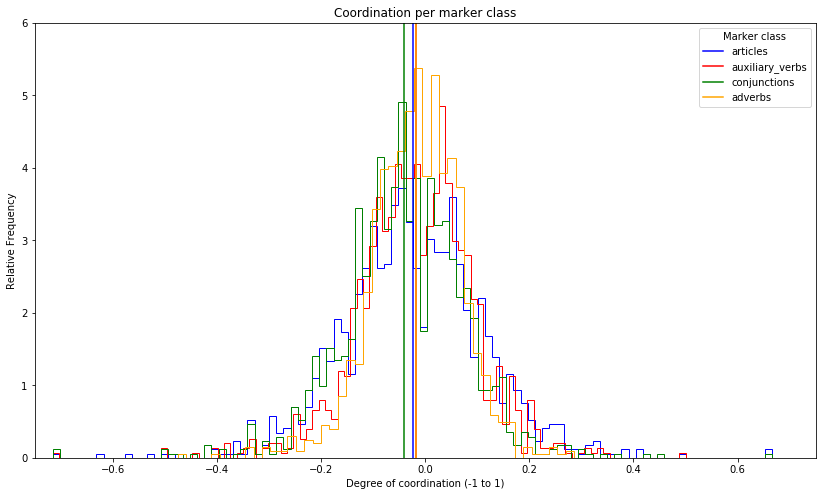

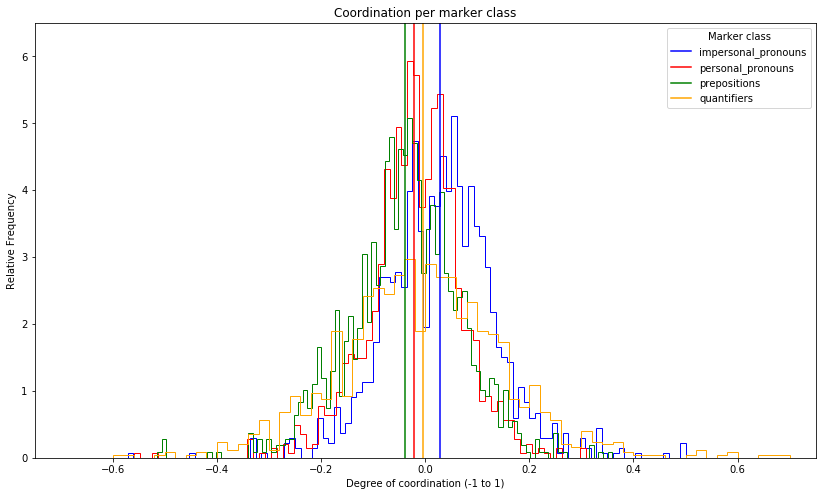

In [54]:
plt.figure(figsize=(14,8))

cdict = dict(zip(markers_names[:4], ['blue', 'red', 'green', 'orange']))

for i, name in enumerate(markers_names[:4]):
    mean = np.mean(marker_coordination[i])
    plt.axvline(x=mean, ymin=0, ymax=1, label=str(name), color=cdict[name])
    n, bins, patches = plt.hist(marker_coordination[i], 100, histtype='step', normed=True, color=cdict[name])
plt.axis([-0.75, 0.75, 0, 6])
plt.title("Coordination per marker class")
plt.xlabel("Degree of coordination (-1 to 1)")
plt.ylabel("Relative Frequency")
plt.legend(title="Marker class")

plt.figure(figsize=(14,8))

cdict = dict(zip(markers_names[4:], ['blue', 'red', 'green', 'orange']))

for i, name in enumerate(markers_names[4:]):
    mean = np.mean(marker_coordination[i+4])
    plt.axvline(x=mean, ymin=0, ymax=1, label=str(name), color=cdict[name])
    n, bins, patches = plt.hist(marker_coordination[i+4], 100, histtype='step', normed=True, color=cdict[name])
plt.axis([-0.75, 0.75, 0, 6.5])
plt.title("Coordination per marker class")
plt.xlabel("Degree of coordination (-1 to 1)")
plt.ylabel("Relative Frequency")
plt.legend(title="Marker class")

In [79]:
# Compute the significance of the outcome
data = []
for i in range(len(markers)):
    data.append(marker_coordination[i])
    print("Average coordination of marker class {}: {} \n\tvariance: {} \tsample size:{}\n".format(markers_names[i], np.mean(data[i]), np.var(data[i]), len(data[i])))

Average coordination of marker class articles: -0.0242769576882 
	variance: 0.0193116232487 	sample size:1247

Average coordination of marker class auxiliary_verbs: -0.0174125743433 
	variance: 0.0126375668144 	sample size:1238

Average coordination of marker class conjunctions: -0.0415833325248 
	variance: 0.014342318462 	sample size:1239

Average coordination of marker class adverbs: -0.0185088345878 
	variance: 0.00864355260826 	sample size:1241

Average coordination of marker class impersonal_pronouns: 0.0290462761864 
	variance: 0.0116619565131 	sample size:1241

Average coordination of marker class personal_pronouns: -0.0207462359914 
	variance: 0.00847690809143 	sample size:1239

Average coordination of marker class prepositions: -0.0389351564046 
	variance: 0.0116000524234 	sample size:1241

Average coordination of marker class quantifiers: -0.00492450384662 
	variance: 0.0281756985044 	sample size:1243



In [87]:
# Print results for t-test
t_test_results = np.zeros([len(markers), len(markers)])

for i in range(len(data)-1):
    for j in range(i+1, len(data)):
        results = scipy.stats.ttest_ind(data[i], data[j], equal_var=False)
        t_test_results[i][j] = results[1]
        t_test_results[j][i] = results[1]

import pandas as pd
pd.DataFrame(t_test_results, columns=markers_names, index=markers_names)

,articles,auxiliary_verbs,conjunctions,adverbs,impersonal_pronouns,personal_pronouns,prepositions,quantifiers
articles,0.000000e+00,1.759761e-01,8.958636e-04,2.237924e-01,4.687250e-26,4.552054e-01,3.311540e-03,1.758404e-03
auxiliary_verbs,1.759761e-01,0.000000e+00,2.441467e-07,7.914695e-01,3.277781e-25,4.197330e-01,1.216338e-06,2.957847e-02
conjunctions,8.958636e-04,2.441467e-07,0.000000e+00,9.308909e-08,2.987072e-51,1.294142e-06,5.628398e-01,4.538461e-10
adverbs,2.237924e-01,7.914695e-01,9.308909e-08,0.000000e+00,4.725811e-31,5.472966e-01,4.614804e-07,1.269698e-02
impersonal_pronouns,4.687250e-26,3.277781e-25,2.987072e-51,4.725811e-31,0.000000e+00,4.977563e-34,5.291313e-53,2.360003e-09
personal_pronouns,4.552054e-01,4.197330e-01,1.294142e-06,5.472966e-01,4.977563e-34,0.000000e+00,6.518817e-06,3.639570e-03
prepositions,3.311540e-03,1.216338e-06,5.628398e-01,4.614804e-07,5.291313e-53,6.518817e-06,0.000000e+00,2.198877e-09
quantifiers,1.758404e-03,2.957847e-02,4.538461e-10,1.269698e-02,2.360003e-09,3.639570e-03,2.198877e-09,0.000000e+00


**Answer:**

**Question 3 (20 points)**

Choose three speakers that participated in at least 10 telephone conversations and compute their coordination on 3 different markers (consider markers for which there is sufficient information) for all conversations they participated in.

In [89]:
callers = defaultdict(lambda: list())

for transcript in corpus.iter_transcripts():
    callers[transcript.from_caller_id].append(transcript.swda_filename)
    callers[transcript.to_caller_id].append(transcript.swda_filename)
    

transcript 645


In [90]:
markers = [conjunctions, impersonal_pronouns, prepositions]
markers_names = ['conjunctions', 'impersonal_pronouns', 'prepositions']

callers_sorted = sorted(calers, key=lambda k: len(callers[k]), reverse=True)

data = defaultdict(lambda: list())

for i in range(3):
    caller_id = callers_sorted[i]
    transcripts = callers[caller_id]
    print("Caller {} recorded {} conversations".format(caller_id, len(transcripts)))
    
    marker_coordination = defaultdict(lambda : list())
    marker_counter = defaultdict(lambda : 0)
    
    for transcript_file in transcripts:
        transcript = Transcript(transcript_file, 'swda_time/swda-metadata-ext.csv')
        if transcript.from_caller_id == caller_id:
            speaker = 'A'
        else: 
            speaker = 'B'
    
        alignments = compute_coordination(transcript, speaker, markers)
        for marker_id, alignment in enumerate(alignments):
            if alignment:
                marker_coordination[marker_id].append(alignment)
                
    for i in range(len(markers)):
        data[caller_id].append(marker_coordination[i])
        print("Caller {} coordination w.r.t. other speakers in marker class {}: {} \n\tvariance: {} \tsample size:{}\n".format(caller_id, markers_names[i], np.mean(data[caller_id][i]), np.var(data[caller_id][i]), len(data[caller_id][i])))

Caller 1533 recorded 12 conversations
Caller 1533 coordination w.r.t. other speakers in marker class conjunctions: -0.00701394306951 
	variance: 0.00698947004227 	sample size:11

Caller 1533 coordination w.r.t. other speakers in marker class impersonal_pronouns: 0.0356275097774 
	variance: 0.00952752902715 	sample size:11

Caller 1533 coordination w.r.t. other speakers in marker class prepositions: -0.0158419592922 
	variance: 0.00541198026266 	sample size:12

Caller 1531 recorded 12 conversations
Caller 1531 coordination w.r.t. other speakers in marker class conjunctions: 0.0455096671006 
	variance: 0.0180027321146 	sample size:11

Caller 1531 coordination w.r.t. other speakers in marker class impersonal_pronouns: 0.00193507472919 
	variance: 0.00765762078195 	sample size:12

Caller 1531 coordination w.r.t. other speakers in marker class prepositions: -0.0131062119698 
	variance: 0.0126041291637 	sample size:11

Caller 1190 recorded 11 conversations
Caller 1190 coordination w.r.t. oth

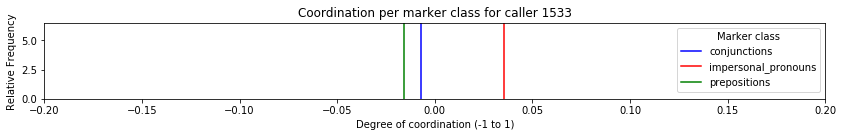

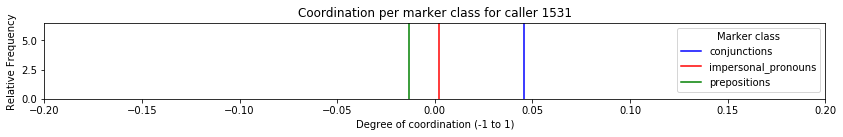

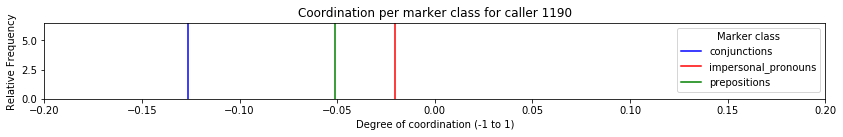

In [91]:
for i in range(3):
    caller_id = callers_sorted[i]
    caller_data = data[caller_id]
    plt.figure(figsize=(14,1.4))
    
    cdict = dict(zip(markers_names, ['blue', 'red', 'green']))
    
    for i, name in enumerate(markers_names):
        mean = np.mean(caller_data[i])
        plt.axvline(x=mean, ymin=0, ymax=1, label=str(name), color=cdict[name])
#         n, bins, patches = plt.hist(caller_data[i], 100, histtype='step', normed=True, color=cdict[name])
    plt.axis([-0.2, 0.2, 0, 6.5])
    plt.title("Coordination per marker class for caller {}".format(caller_id))
    plt.xlabel("Degree of coordination (-1 to 1)")
    plt.ylabel("Relative Frequency")
    plt.legend(title="Marker class")

In [104]:
# Print results for t-test
for caller_id in data.keys():
    caller_data = data[caller_id]    
    print("\nStatistics for caller {}".format(caller_id))
    for i in range(len(caller_data)-1):
        for j in range(i+1, len(caller_data)):    
            results = scipy.stats.ttest_ind(caller_data[i], caller_data[j], equal_var=False)
            print('{} vs. {}: T: {}\t p-value :{p:1.4e}'.format(markers_names[i], markers_names[j], results[0], p=results[1]))
        

# Print results for t-test
caller_ids = data.keys()

for c, caller_id in enumerate(caller_ids):
    caller_data = data[caller_id]    
    for other_id in caller_ids[c+1:]:  
        print("\nStatistics for caller {} vs. caller {}".format(caller_id, other_id))
        for i in range(len(caller_data)):            
            other_data = data[other_id] 
            results = scipy.stats.ttest_ind(caller_data[i], other_data[i], equal_var=False)
            print('{}: T: {}\t p-value :{p:1.4e}'.format(markers_names[i], results[0], p=results[1]))


Statistics for caller 1190
conjunctions vs. impersonal_pronouns: T: -1.86483661692	 p-value :7.8755e-02
conjunctions vs. prepositions: T: -1.60646577709	 p-value :1.2699e-01
impersonal_pronouns vs. prepositions: T: 0.61161365904	 p-value :5.4958e-01

Statistics for caller 1533
conjunctions vs. impersonal_pronouns: T: -1.04921966331	 p-value :3.0688e-01
conjunctions vs. prepositions: T: 0.255809831463	 p-value :8.0071e-01
impersonal_pronouns vs. prepositions: T: 1.35410758308	 p-value :1.9201e-01

Statistics for caller 1531
conjunctions vs. impersonal_pronouns: T: 0.872116409563	 p-value :3.9535e-01
conjunctions vs. prepositions: T: 1.05951201242	 p-value :3.0238e-01
impersonal_pronouns vs. prepositions: T: 0.340046551719	 p-value :7.3758e-01

Statistics for caller 1190 vs. caller 1533
conjunctions: T: -2.57356570647	 p-value :2.0162e-02
impersonal_pronouns: T: -1.07594179886	 p-value :2.9708e-01
prepositions: T: -1.00605774629	 p-value :3.2654e-01

Statistics for caller 1190 vs. calle

**Answer:**

## How to compute overall coordination

It is not straightforward to devise a formula for the overall level of coordination (i.e., with respect to all linguistic markers at the same time). Just taking an average over all different values is not appropriate, as we may not have enough data to compute reliable estimates for all markers, or certain speakers might not use some markers at all. To not exclude too many speakers, we will take the average of $C_m(B,A)$ for all $m$ for which at least one of B's utterances exhibits marker $m$ (this corresponds to aggregated 3 in Danescu-Niculescu-Mizil et al., 2012).

## (A)symmetry of coordination

**Question 4 (25 points)**

In this question you will investigate the (a)symmetry of coordination. For each conversation, compare the overall coordination of speaker A towards speaker B with the coordination of B towards A by computing the difference $D$ between these two coordination levels. How is the difference $D$ distributed? Based on this distribution, does the level of coordination seem somewhat symmetric?

Answer:
*Your findings*

In [12]:
# Code supporting your answer

## Influence of demographic variables on coordination

** Question 5 (25 points)** 

Pick a demographic variable (e.g. age, gender, education) and test if there is a significant difference in coordination. Plot the coordination values and provide a statistical analysis of your result.

Answer:
*Explanation of findings*

*Provide analysis of results*

In [13]:
# Plot results

In [14]:
# statistical tests supporting your results

** Bonus question (10 points)**

Your own question.